Train dataset shape: (550068, 12)
Test dataset shape: (233599, 11)

Train dataset head:
   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1         

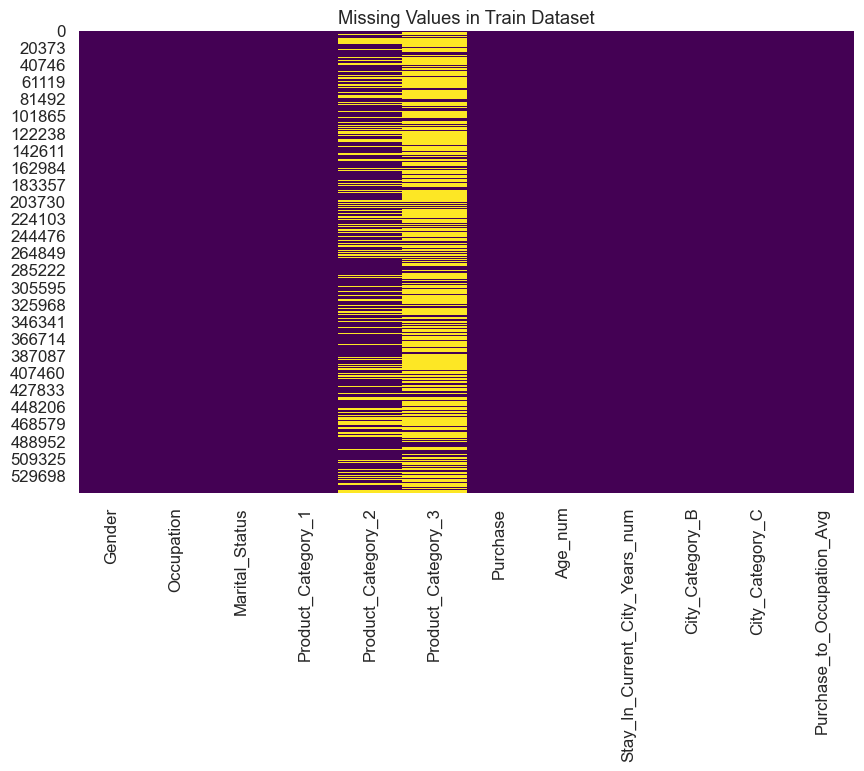

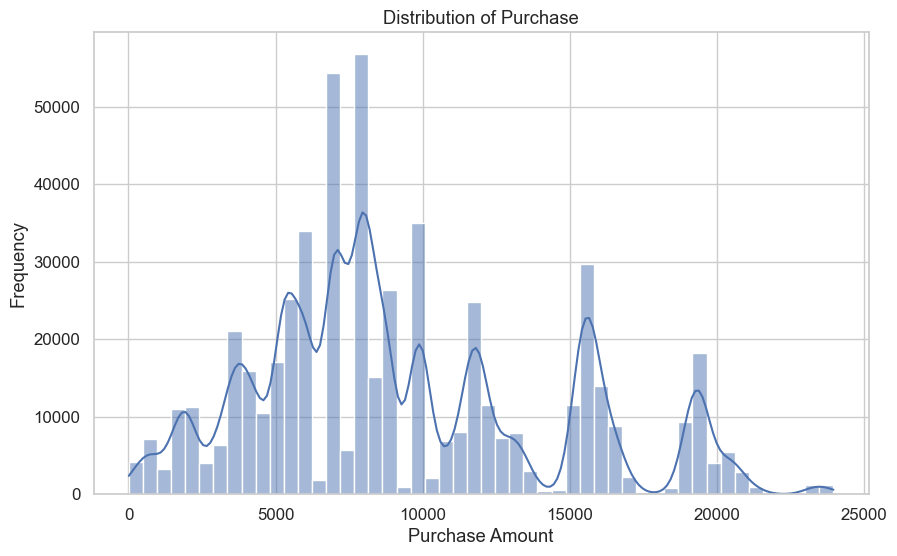

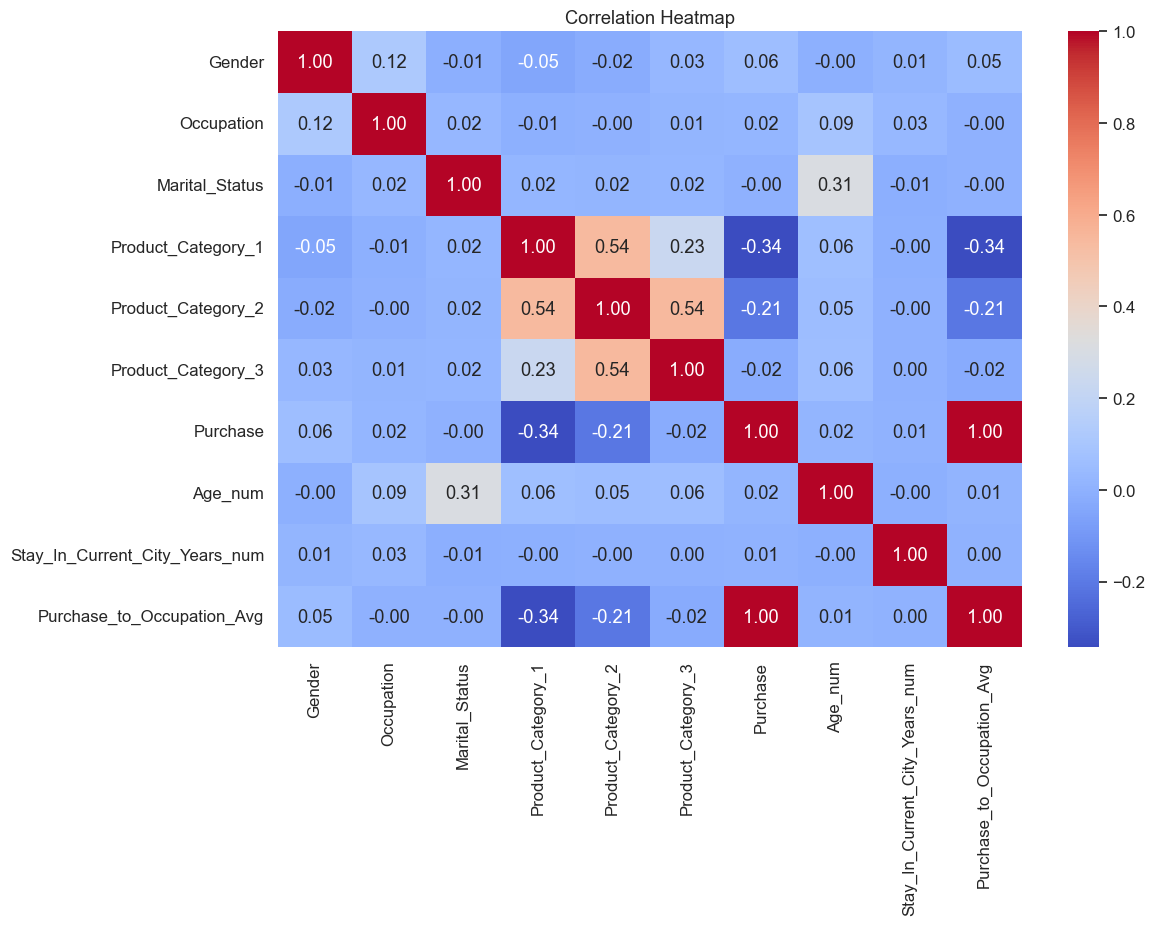

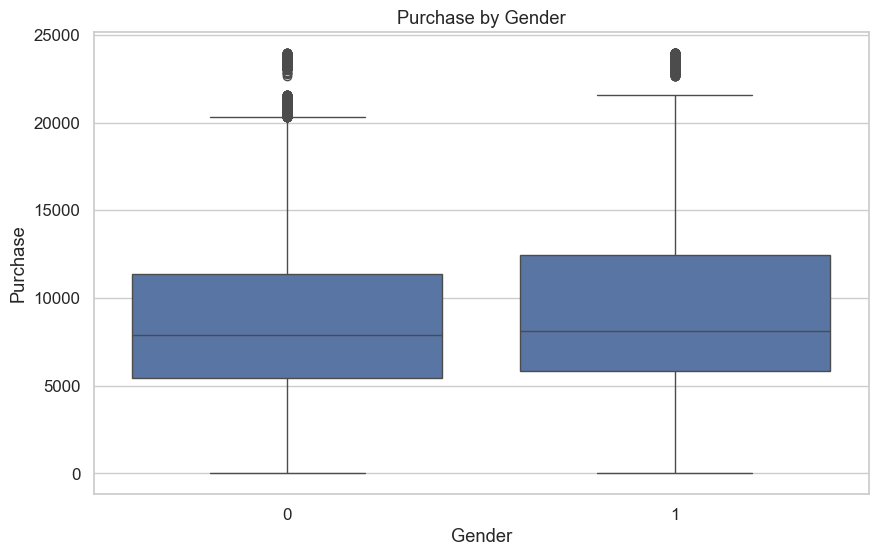

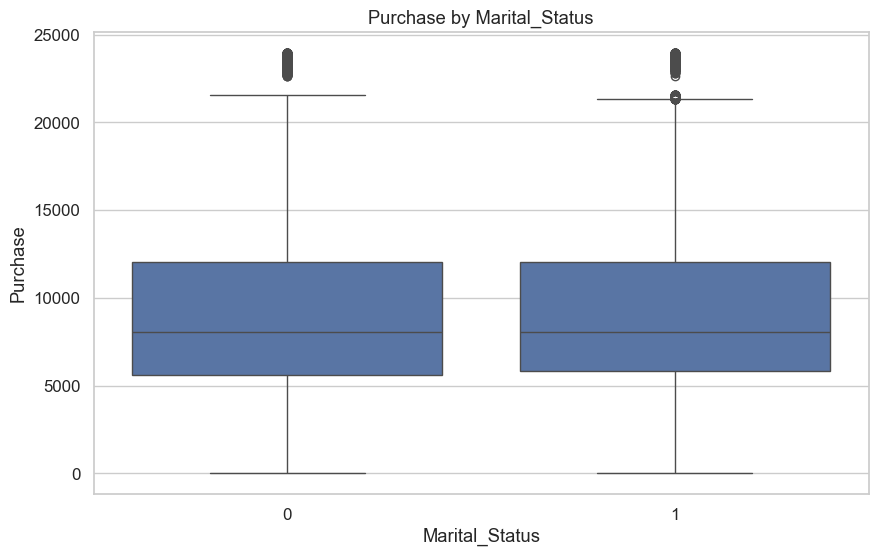

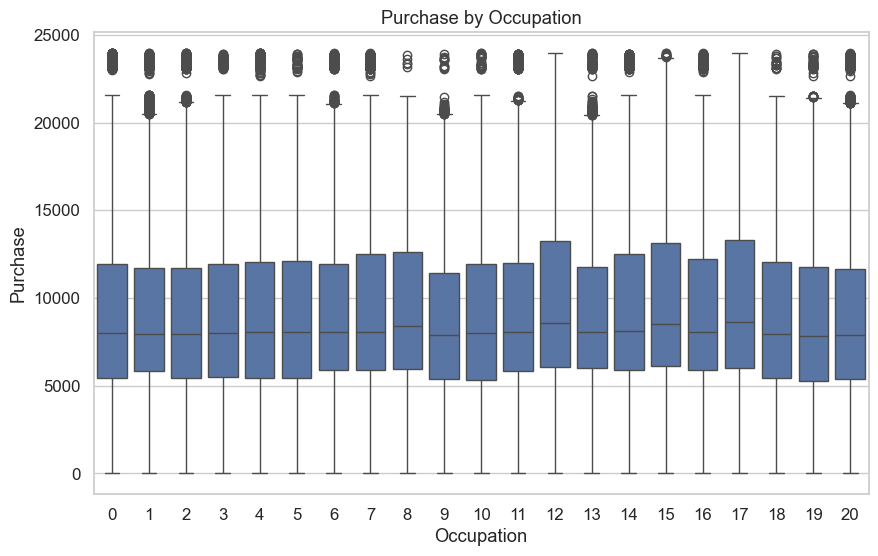

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Validation RMSE: 15.31
Validation R2: 1.00


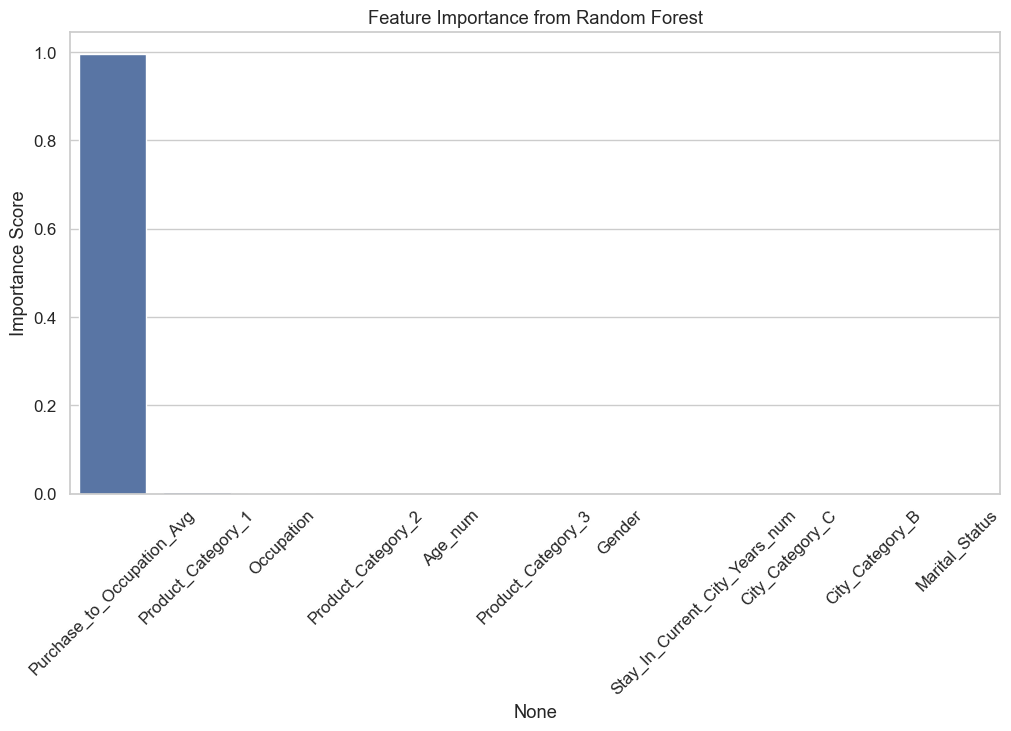

First 10 predictions on test set:
[20640.31750397 20672.70493651 20643.24821429 20657.39122222
 20660.78978968 20652.6549881  20638.51198016 20648.59340079
 23737.16434091 20659.70028968]


In [8]:
# Optimized Black Friday Dataset Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Visualization config
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

# ---------------------------
# 1. Data Import & Cleaning
# ---------------------------
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Dataset Overview
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

print("\nTrain dataset head:")
print(train_df.head())

print("\nMissing values in Train dataset:")
print(train_df.isnull().sum())

print("\nSummary statistics for Train dataset:")
print(train_df.describe())

# Drop duplicates
train_df.drop_duplicates(inplace=True)

# ---------------------------
# 2. Data Preprocessing
# ---------------------------
le = LabelEncoder()
for df in [train_df, test_df]:
    df['Gender'] = le.fit_transform(df['Gender'])
    df['Age_num'] = df['Age'].map({'0-17': 1, '18-25': 2, '26-35': 3, '36-45': 4, '46-50': 5, '51-55': 6, '55+': 7})
    df['Stay_In_Current_City_Years_num'] = df['Stay_In_Current_City_Years'].replace({'4+': 4}).astype(int)

train_df = pd.get_dummies(train_df, columns=['City_Category'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['City_Category'], drop_first=True)

# Feature Engineering: Purchase_to_Occupation_Avg
occupation_avg = train_df.groupby('Occupation')['Purchase'].mean()
train_df['Purchase_to_Occupation_Avg'] = train_df['Purchase'] / train_df['Occupation'].map(occupation_avg)
test_df['Purchase_to_Occupation_Avg'] = test_df['Occupation'].map(occupation_avg)

# Drop now-unnecessary columns
cols_to_drop = ['User_ID', 'Product_ID', 'Age', 'Stay_In_Current_City_Years']
train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

# Align test_df to train_df
missing_cols = set(train_df.columns) - set(test_df.columns) - {'Purchase'}
for col in missing_cols:
    test_df[col] = 0
test_df = test_df[[col for col in train_df.columns if col != 'Purchase']]

# ---------------------------
# 3. EDA Plots
# ---------------------------
# Missing values heatmap
plt.figure()
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Train Dataset")
plt.show()

# Distribution of Purchase
plt.figure()
sns.histplot(train_df['Purchase'], bins=50, kde=True)
plt.title("Distribution of Purchase")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")
plt.show()

# Correlation Heatmap
numeric_cols = train_df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Boxplots: Purchase vs. Gender, Marital_Status, Occupation
for feature in ['Gender', 'Marital_Status', 'Occupation']:
    plt.figure()
    sns.boxplot(x=feature, y='Purchase', data=train_df)
    plt.title(f"Purchase by {feature}")
    plt.show()

# ---------------------------
# 4. Prepare Features & Scaling
# ---------------------------
X = train_df.drop(columns=['Purchase'])
y = train_df['Purchase']

scaler = StandardScaler()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[num_cols] = scaler.fit_transform(X[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 5. Model Training
# ---------------------------
rf = RandomForestRegressor(random_state=42)
param_dist = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=5,
    scoring='neg_mean_squared_error', cv=2,
    verbose=1, n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_

# ---------------------------
# 6. Evaluation
# ---------------------------
y_pred = best_rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R2: {r2:.2f}")

# Feature Importance
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=importances.index, y=importances.values)
plt.xticks(rotation=45)
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.show()

# ---------------------------
# 7. Predict on Test Data
# ---------------------------
test_predictions = best_rf.predict(test_df)
print("First 10 predictions on test set:")
print(test_predictions[:10])
